In [1]:

import os
import sys
dir_project = os.path.dirname(os.getcwd())
path = os.path.join(dir_project, 'src')
if path not in sys.path:
    sys.path.append(path)

current_directory = os.getcwd()
#os.chdir(os.path.join(dir_project, 'src'))
print("Current Working Directory:", os.getcwd())
from iglabel import *
from seqlp.setup.read_fasta import ParseFasta

Current Working Directory: c:\Users\nilsh\my_projects\SeqLP\jupyter_scripts


In [3]:

seq_header:dict = ParseFasta.read_fasta(r"C:\Users\nilsh\OneDrive\Desktop\results_thesis\data\structures\chainA.fasta")
nanobody_lab = seq_header["cbtx_nanobody_refine_22_A"]


positions_cdr1 = list(range(25,32))
positions_cdr2 = list(range(50, 57))
cdr3 = list(range(94, (94+23)))
positions = positions_cdr1 + positions_cdr2 + cdr3
print(nanobody_lab[25:32])
print(nanobody_lab[50:57])
print(nanobody_lab[94:95+23])


GDIGGLK
KRNENEA
CNAVVGNWYTSGYYEDTYWGQGTQ


In [2]:
from seqlp.visualize.load_model import LoadModel
from seqlp.visualize.bertology import Bertology, PlotAttention

Setup = LoadModel(model_path = os.path.join(dir_project, "tests", "test_data", r"nanobody_model"))
Setup.tokenizer()

c:\Users\nilsh\my_projects\SeqLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of EsmModel were not initialized from the model checkpoint at c:\Users\nilsh\my_projects\SeqLP\tests\test_data\nanobody_model and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: You need to specify either `text` or `text_target`.

In [4]:
from seqlp.visualize.load_model import LoadModel
from seqlp.visualize.bertology import Bertology, PlotAttention

Setup = LoadModel(model_path = os.path.join(dir_project, "tests", "test_data", r"nanobody_model"))
attentions = Setup.get_attention(sequence = [nanobody_lab])
Berto = Bertology(residues = positions, sequence = nanobody_lab, decision_function = "binding_site")
pa_f = Berto.compute_pa_f_fast(attentions)

Some weights of EsmModel were not initialized from the model checkpoint at c:\Users\nilsh\my_projects\SeqLP\tests\test_data\nanobody_model and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


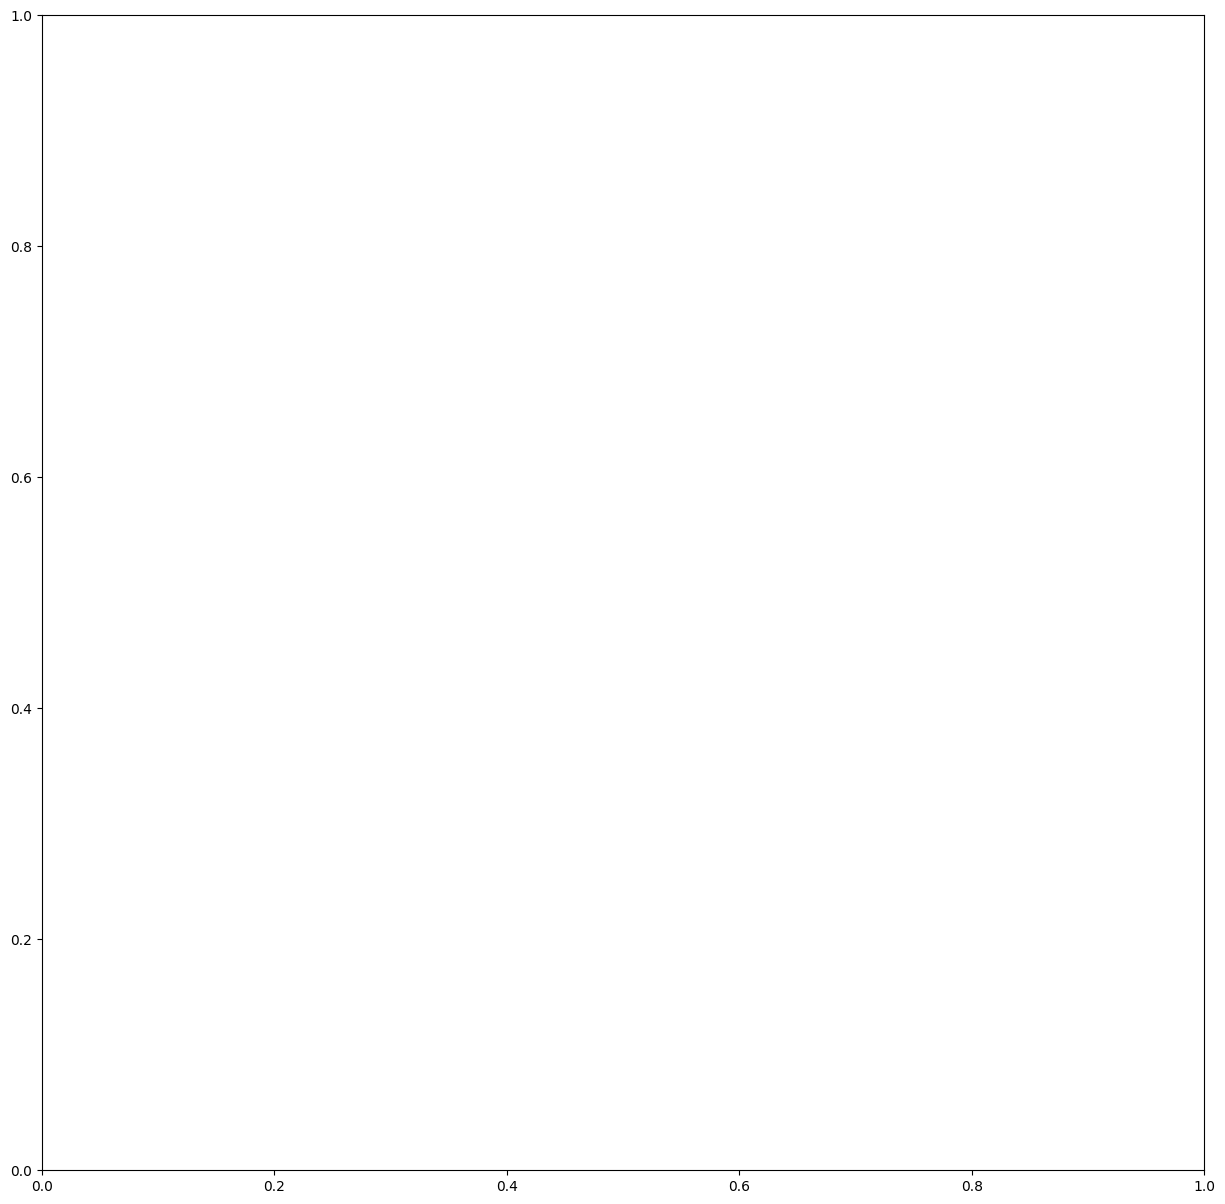

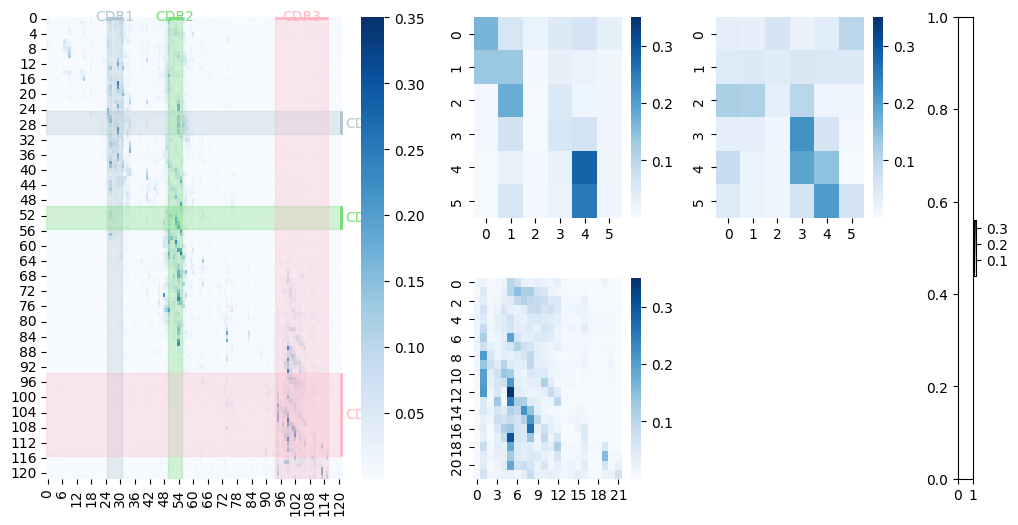

In [5]:
import matplotlib.pyplot as plt
import numpy as np 
fig = plt.figure(1, figsize=(15, 15))
ax = fig.gca()
residues_cdr = [positions_cdr1, positions_cdr2, cdr3]
Plotter = PlotAttention(matrix = pa_f, figure_no = 2, cmap = "Blues", ax = ax)
Plotter.create_region_specific_subplot(sequence = nanobody_lab,residues = residues_cdr,last_residue = len(nanobody_lab), attentions = attentions, no_heads_average = 3)
#Plotter.ax.set_xticks(np.arange(len(nanobody_lab)),  )
#Plotter.ax.set_xticklabels(list(nanobody_lab), rotation=0) 


![My Image](../contacts_cdr3_cablacizumab.png)

## Interpretation of heatmap combined with 3d model

- cdr3 regions shows very high attentions to contacts in close proximity 
    -> this indicates a local interaction which can be seen with the residues in the 3d model. 
    -> this could also mean that the local structure is rather circular then linear.

- cdr2 and cdr1 show a more distributed attention to contacts
    -> could indicate that those are more dependent on backbone and fr regions 
- not many cross attentions within the corresponding complementary regions.
    -> this could indicate that the cdr loop which is in contact to the antigen can be modified by switching residues witout affecting the structure of the loop?

    

# CDR3 embeddings of CDR3 sequences of nanobodies selected by FACS and grouped as non-binders, alpha bungarotoxin binders and consensus long neurotoxin binders

aBGTX = alpha bungarotoxin
cLNTX = consensus long neurotoxin
++ = cross binder 
-+ mono binder

![My Image](../all_samples_nanobody_model_all_seqs.png)


What you can see:
- a lot of non-binders cluster separately in a big cluster in the center 
    - model can capture the difference between binders and non-binders
- consensus longneurotoxin binders and alpha bungarotoxin binders cluster partially separately
- crossbinders cluster in own cluster

-> it shows that the model can capture probably structural differences between those binders 

### Resulting Questions:

- Which residues are important for binding in certain clusters?
- Can we distinguish based on attention of connected residues between binders and non-binders in the same cluster?


## Which residues are improtant for binding in the highlighted cluster?

### Prepare the sub clusters of the bigger cluster

We perform a multiple sequence alignment to identify the following:
1. Fixed residues which are probably important for binding, since they are conserved
2. Find multiple sub cluster in the cluster of around 100 sequences, since there are also non binders, and here you can cluster based on patterns within the multiple sequence alignment

    2.1 So you have some clusters which are probably the binders and some which are non binders, and maybe some in between
    
    2.2 The clusters are generated based on levenshtein distance of the multiple sequence aligned sequences. Default threshold is 20 % difference based on levenshtein distance.

In [ ]:
from seqlp.visualize.msa_cluster import MSACluster
import os

file = os.path.abspath(r"C:\Users\nilsh\my_projects\SeqLP\tests\test_data\aligned_sequences.fasta")

aligned_sequences = MSACluster().run_msa(r"C:\Users\nilsh\Downloads\muscle3.8.31_i86win32.exe", file) # multiple sequence alignment

clusters = MSACluster().distance_on_gaps(aligned_sequences, max_distance_percent= 0.3) # clustering based on levenshtein distance

fixed_positions = MSACluster().find_fixed_positions(clusters) # find conserved residues and extract (residue positions are for multiple sequence alignment with gaps)



In [ ]:
print(fixed_positions)
specific_cluster = fixed_positions[1]

reference_sequence, adjusted_positions = MSACluster.translate_positions(specific_cluster) # translate residue positions to sequence positions without gaps


### Setup the model and process attentions

Here you load the model of your choice. As an example a pretrained model on heavy chains is chosen. After that you return the attention weights of the model.
 The class Berto uses those, combined with the adjusted positions to find attention heads which describe the conserved residues in the best ways.

The output is a matrix with size (batch_size, number_layers, number_heads) which shows the average attention given the parsed positions for the model's heads.


In [ ]:
from seqlp.visualize.setup_model import SetupModel
from seqlp.visualize.bertology import Bertology, PlotAttention

Setup = SetupModel(model_path = os.path.join(dir_project, "tests", "test_data", r"nanobody_model"))
attentions = Setup.get_attention(sequence = [reference_sequence])
Berto = Bertology(residues = adjusted_positions, sequence = reference_sequence, decision_function = "binding_site")
pa_f = Berto.compute_pa_f(attentions)

In [ ]:
Plotter = PlotAttention(matrix = pa_f, figure_no = 1, cmap = "Blues")
Plotter.plot_mean_head(sequence = reference_sequence, residues = adjusted_positions)

### What does the average attention over the model tell us?

- High values: Those are the ones you are looking for because they represent in the most suitable way your contact interaction between the fixed residues
- Low values: Those are the ones you are not interested in, because they are not less important for the interaction

**Interpreting the plot specifically**

- in layer 1 and 2 are the best sutiable heads
- the attention for all heads is relatively high which is not good
    - i could try to decrease the number of positions, I parsed to see a larger gradient between the attention heads
- Maybe the model is too small because of the above mentioned issue ( so it is not very decisive)
- Because we have so many suitable heads we should limit the number to average over those to a small number of heads.
    - I will choose the top three heads for the next step

### What does the residue vs residue plot tell us?

- high diagonal values: There could be a certain type of directionality of residue residue interaction
    - however, you can see that withing this diagonal line are htospots which indicate high neighbored contacts between those residues
- hgih off diagonal values: 

BErtology on own nanobody sequence

In [ ]:
sequences = Bertology.extract_sequence_from_pdb(r"C:\Users\nilsh\OneDrive\Desktop\results_thesis\data\cbtx_nanobody_refine_22.pdb")
first_seq = str(sequences[0])
first_seq

In [ ]:
Setup = LoadModel(model_path = os.path.join(dir_project, "tests", "test_data", r"nanobody_model")) # you can load any model here
attentions = Setup.get_attention(sequence = [first_seq])
Berto = Bertology(residues = positions, sequence = first_seq, decision_function = "binding_site")
pa_f = Berto.compute_pa_f_fast(attentions)

In [ ]:
import seaborn as sns

fig = plt.figure(1, figsize=(10, 10))
ax = fig.gca()
layers_head_tensor = pa_f[0, :, :]
layers_head_numpy = layers_head_tensor.cpu().numpy()
sns.heatmap(layers_head_numpy, ax = ax, cmap = "Blues") # upper row represents the first layer
ax.set_xlabel("Heads")
ax.set_ylabel("Layers")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
from seqlp.use_model import AnalyseModel


font_normal = AnalyseModel(os.path.join(dir_project, "tests", "test_data", r"nanobody_model")).font_settings_normal
font_title = AnalyseModel(os.path.join(dir_project, "tests", "test_data", r"nanobody_model")).font_settings_title
fig = plt.figure(1, figsize=(10, 10))
ax = fig.gca()

Plotter = PlotAttention(matrix = pa_f, figure_no = 2, cmap = "Blues", ax = ax)
Plotter.plot_residue_residue(sequence = first_seq, attentions = attentions, no_heads_average = 1)


# Centering the labels
x_positions = np.arange(len(first_seq)) + 0.5
y_positions = np.arange(len(first_seq)) + 0.5
list_seq = list(first_seq)

# Showing only every fifth index
ax.set_xticks(x_positions[::10])
ax.set_xticklabels(positions[::10], rotation=0, ha='center', )  # Rotate labels to 45 degrees


ax.set_yticks(y_positions[::10])
ax.set_yticklabels(positions[::10], )

Plotter.ax.set_xlabel("Residue Position", **font_normal)
Plotter.ax.set_ylabel("Residue Position", **font_normal)
cbar = Plotter.ax.collections[0].colorbar
cbar.set_label('Attention weight')
plt.title("Attention Head for a nanobody sequence as input",pad = 20, **font_title)
AnalyseModel(os.path.join(dir_project, "tests", "test_data", r"nanobody_model")).save_in_plots("example_attention_head_full_nanobody_sequence.png")


Compare to esm model 

In [ ]:
Setup = LoadModel(model_path ="facebook/esm2_t6_8M_UR50D") # you can load any model here
attentions = Setup.get_attention(sequence = [first_seq])
Berto = Bertology(residues = positions, sequence = first_seq, decision_function = "binding_site")
pa_f = Berto.compute_pa_f_fast(attentions)

In [ ]:
fig = plt.figure(1, figsize=(20, 20))
ax = fig.gca()

Plotter = PlotAttention(matrix = pa_f, figure_no = 2, cmap = "Blues", ax = ax)
Plotter.plot_residue_residue(sequence = first_seq, attentions = attentions, no_heads_average = 3)
Plotter.ax.set_xticks(np.arange(len(first_seq)),  )
Plotter.ax.set_xticklabels(list(first_seq), rotation=0) 